<a href="https://colab.research.google.com/github/Ryan-RE-Wang/NTHU_ML-HW2/blob/main/ML_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preprocess

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from joblib import dump, load
from scipy import stats
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
import warnings
warnings.simplefilter("ignore")

# df = pd.read_csv('hm_hospitales_covid_structured_30d_train.csv', index_col=0)
# label = pd.read_csv('split_train_export_30d.csv', index_col=0)
output_df = pd.read_csv('fixed_test.csv', index_col=0)

In [ ]:
def preprocess(df):
  df['sex'] = df['sex'].replace({'MALE':0, 'FEMALE':1})

  col = df.columns[9:21]

  for i in col:
    df[i] = df[i].fillna(0)

  df[sorted(df['ed_diagnosis'].unique())] = 0

  for j in df.index:
    symptom = df['ed_diagnosis'][j]
    df[symptom][j] = 1

  df = df.drop(['ed_diagnosis'], axis=1)

  numerical_col = []
  for i in df.columns:
    if (df[i].isnull().sum() != 0):
      numerical_col.append(i)

  for i in numerical_col:
    median = df[i].median(skipna=True)
    df[i] = df[i].fillna(median)

  df = df.drop(['admission_datetime'], axis=1)
  df = df.drop(symptom, axis=1)

  return df

# Run XGboost model

In [ ]:
clf = load('XGboost_model.joblib')

output_df = preprocess(output_df)
outcome = output_df.drop(output_df.columns, axis=1)

outcome['hospital_outcome'] = clf.predict(output_df)

In [ ]:
outcome

,hospital_outcome
PATIENT ID,
1636,0
734,1
1045,1
1728,0
1267,0
...,...
1735,1
1807,1
1464,0


# Plot and RandomizedSearchCV 

In [ ]:
def Plot_ROC_Curve(model, X_test, y_test):
  # calculate the fpr and tpr for all thresholds of the classification

  y_pred = model.predict(X_test)
  fpr, tpr, threshold = roc_curve(y_test, y_pred)
  roc_auc = auc(fpr, tpr)

  plot_roc_curve(model, X_test, y_test)
  plt.show()

  print(classification_report(y_test, y_pred))

In [ ]:
def get_param(model_type):
  if (model_type == 'xgboost'):
    param_dist = {'n_estimators': stats.randint(100, 1000),
                'learning_rate': stats.uniform(0.01, 0.6),
                'subsample': stats.uniform(0.3, 0.9),
                'max_depth': range(3, 100),
                'colsample_bytree': stats.uniform(0.3, 0.8),
                'min_child_weight': stats.randint(1, 5)
            }

  elif (model_type == 'tree'):
    param_dist = {"max_depth": stats.randint(3, 10),
            "max_features": stats.randint(1, 9),
            "min_samples_leaf": stats.randint(1, 9),
            "criterion": ["gini", "entropy"]
            }

  elif (model_type == 'rf'):
    param_dist = {'bootstrap': [True, False],
               'max_depth': stats.randint(10, 120),
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': stats.randint(1, 15),
               'min_samples_split': stats.randint(1, 20),
               'n_estimators': stats.randint(100, 250)
            }
  elif (model_type == 'gb'):
    param_dist = {
              "loss":["deviance"],
              "learning_rate": stats.uniform(0.01, 0.2),
              "min_samples_split": stats.randint(1, 5),
              "min_samples_leaf": stats.randint(1, 3),
              "max_depth":stats.randint(3, 8),
              "criterion": ["friedman_mse"],
              "subsample":stats.uniform(0.5, 1.5),
              "n_estimators":stats.randint(80, 120)
    }
  elif (model_type == 'svm'):
    param_dist = {
            "C": stats.randint(0.01, 2)
    } 

  elif (model_type == 'logistic'):
    param_dist = {
              'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['liblinear']
    }

  elif (model_type == 'knn'):
    param_dist = {
              'n_neighbors': stats.randint(3, 8),
              'p': stats.randint(2, 10)
    }
  
  elif (model_type == 'adb'):
    param_dist={
            'learning_rate':stats.uniform(0.01, 0.2),
            'n_estimators':stats.randint(100, 600),
      }

  elif (model_type == 'nb'):
    param_dist={
        'alpha':stats.uniform(0, 2)
    }

  else:
    param_dist={}

  return param_dist

In [ ]:
def oversampling(X_train, y_train):

  sm = SMOTE(sampling_strategy='minority', random_state=7)

  X_oversample, y_oversample = sm.fit_sample(X_train, y_train)

  X_oversample = pd.DataFrame(X_oversample)
  X_oversample.columns = df.columns

  y_oversample = pd.DataFrame(y_oversample)
  y_oversample.columns = label.columns

  return X_oversample, y_oversample

In [ ]:
def build_model(model, model_type):

  X_train, X_test, y_train, y_test = train_test_split(df, label, test_size=0.25, random_state=50)

  param_dist = get_param(model_type)

  kfold = KFold(n_splits=5 ,shuffle=True ,random_state=50)

  clf = RandomizedSearchCV(model, 
                param_distributions = param_dist,
                cv = kfold,  
                n_iter = 5, 
                scoring = 'roc_auc', 
                error_score = 0, 
                verbose = 3, 
                n_jobs = -1)

  X_train, y_train = oversampling(X_train, y_train)

  clf.fit(X_train, y_train)

  # print(clf.best_params_)

  Plot_ROC_Curve(clf, X_test, y_test)

  return clf

# Model


In [ ]:
df = preprocess(df)

X_train, X_test, y_train, y_test = train_test_split(df, label, test_size=0.2, random_state=50)

In [ ]:
import xgboost as xgb

clf_xgb = xgb.XGBClassifier(booster='gbtree', colsample_bytree=0.8, learning_rate=0.02, max_depth=7, min_child_weight=1, missing=-999, 
                      n_estimators=177, objective='binary:logistic', scale_pos_weight=1, seed=1337, silent=0, subsample=0.6, gamma=0.1)

model = build_model(clf_xgb, 'xgboost')

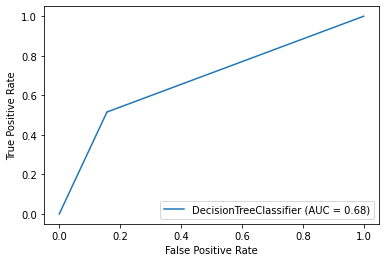

              precision    recall  f1-score   support

           0       0.92      0.84      0.88       401
           1       0.32      0.52      0.40        58

    accuracy                           0.80       459
   macro avg       0.62      0.68      0.64       459
weighted avg       0.85      0.80      0.82       459



In [ ]:
from sklearn import tree

clf_tree = tree.DecisionTreeClassifier()

model = build_model(clf_tree, 'tree')

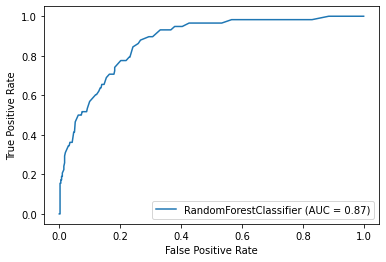

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       401
           1       0.55      0.36      0.44        58

    accuracy                           0.88       459
   macro avg       0.73      0.66      0.69       459
weighted avg       0.87      0.88      0.87       459



In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier()

model = build_model(clf_rf, 'rf')

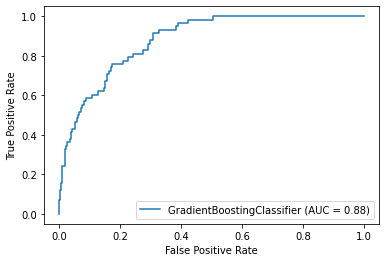

              precision    recall  f1-score   support

           0       0.92      0.95      0.94       401
           1       0.56      0.47      0.51        58

    accuracy                           0.89       459
   macro avg       0.74      0.71      0.72       459
weighted avg       0.88      0.89      0.88       459



In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

clf_gb = GradientBoostingClassifier()

model = build_model(clf_gb, 'gb')

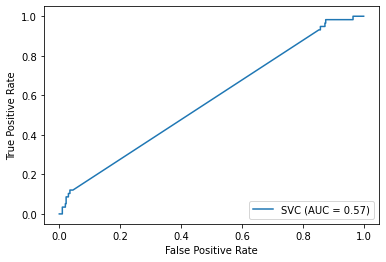

              precision    recall  f1-score   support

           0       0.88      0.97      0.92       401
           1       0.32      0.10      0.16        58

    accuracy                           0.86       459
   macro avg       0.60      0.54      0.54       459
weighted avg       0.81      0.86      0.83       459



In [ ]:
from sklearn.svm import SVC

clf_svm = SVC(gamma='auto', kernel='rbf')

model = build_model(clf_svm, 'svm')

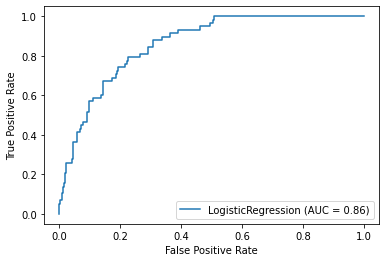

              precision    recall  f1-score   support

           0       0.96      0.73      0.83       401
           1       0.30      0.81      0.44        58

    accuracy                           0.74       459
   macro avg       0.63      0.77      0.64       459
weighted avg       0.88      0.74      0.78       459



In [ ]:
from sklearn.linear_model import LogisticRegression

clf_logistic = LogisticRegression()

model = build_model(clf_logistic, 'logistic')

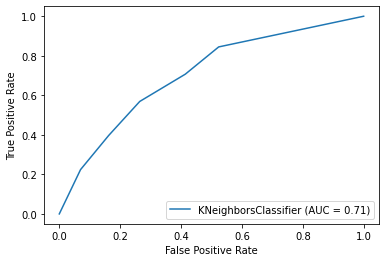

              precision    recall  f1-score   support

           0       0.92      0.74      0.82       401
           1       0.24      0.57      0.34        58

    accuracy                           0.71       459
   macro avg       0.58      0.65      0.58       459
weighted avg       0.84      0.71      0.76       459



In [ ]:
from sklearn.neighbors import KNeighborsClassifier

clf_knn = KNeighborsClassifier()

model = build_model(clf_knn, 'knn')

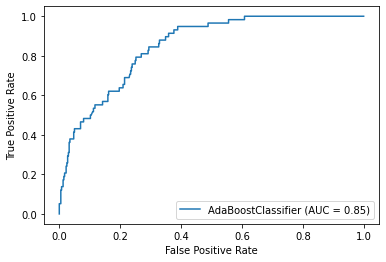

              precision    recall  f1-score   support

           0       0.92      0.91      0.92       401
           1       0.44      0.48      0.46        58

    accuracy                           0.86       459
   macro avg       0.68      0.70      0.69       459
weighted avg       0.86      0.86      0.86       459



In [ ]:
from sklearn.ensemble import AdaBoostClassifier

clf_adb = AdaBoostClassifier()

model = build_model(clf_adb, 'adb')

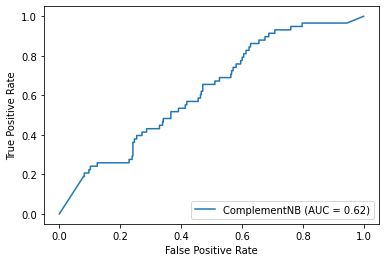

              precision    recall  f1-score   support

           0       0.89      0.92      0.90       401
           1       0.26      0.21      0.23        58

    accuracy                           0.83       459
   macro avg       0.57      0.56      0.57       459
weighted avg       0.81      0.83      0.82       459



In [ ]:
from sklearn.naive_bayes import ComplementNB

clf_cnb = ComplementNB()

model = build_model(clf_cnb, 'nb')

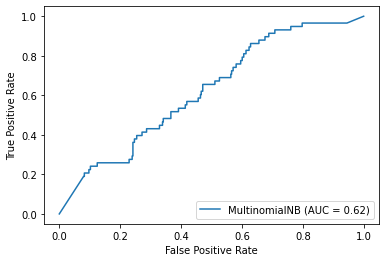

              precision    recall  f1-score   support

           0       0.89      0.92      0.90       401
           1       0.26      0.21      0.23        58

    accuracy                           0.83       459
   macro avg       0.57      0.56      0.57       459
weighted avg       0.81      0.83      0.82       459



In [ ]:
from sklearn.naive_bayes import MultinomialNB

clf_mnb = MultinomialNB()

model = build_model(clf_mnb, 'nb')

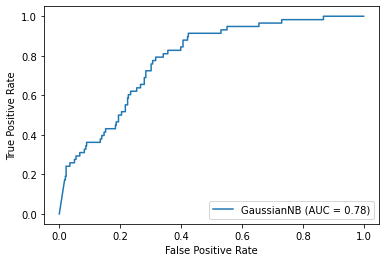

              precision    recall  f1-score   support

           0       0.91      0.90      0.90       401
           1       0.33      0.36      0.35        58

    accuracy                           0.83       459
   macro avg       0.62      0.63      0.62       459
weighted avg       0.83      0.83      0.83       459



In [ ]:
from sklearn.naive_bayes import GaussianNB

clf_gnb = GaussianNB()

model = build_model(clf_gnb, '')

In [ ]:
outcome['hospital_outcome'] = model.predict(output_df)

outcome.to_csv('Prediction: 107062234.csv')

dump(model, 'XGboost_model.joblib') 

# Shap

In [ ]:
import shap

shap.initjs()

model = xgb.train({"learning_rate": 0.01}, xgb.DMatrix(df, label=label), 100)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df)

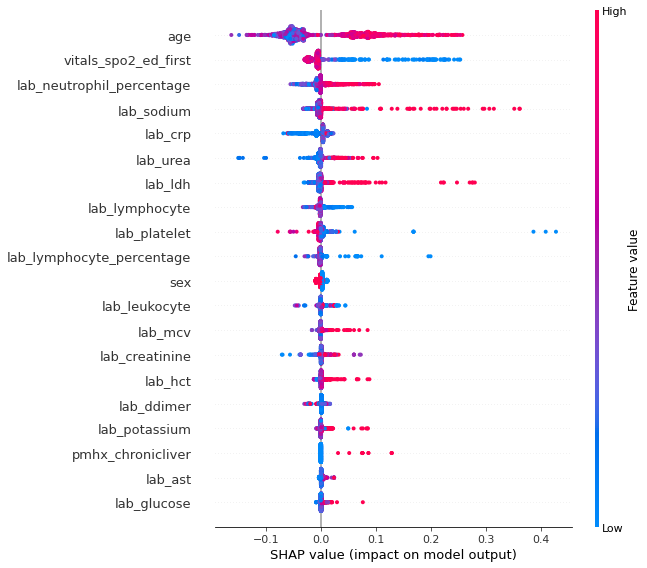

In [ ]:
shap.summary_plot(shap_values, df)

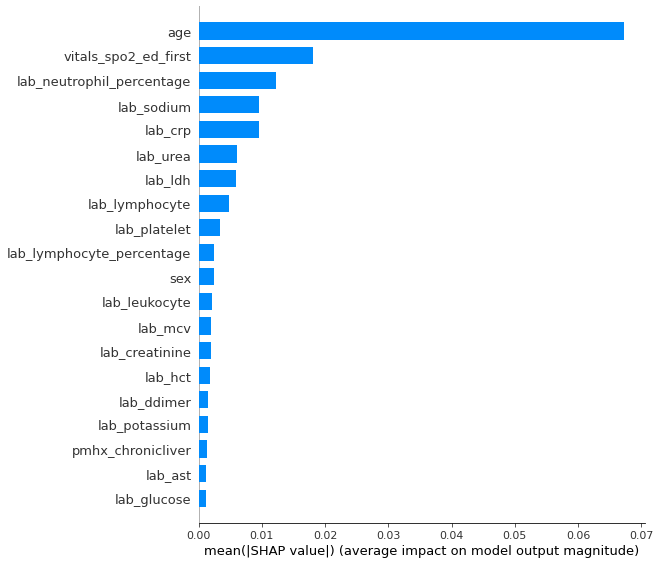

In [ ]:
shap.summary_plot(shap_values, df, plot_type="bar")